In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json, csv

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


# Import Data and useful functions


In [79]:
import os 
 
def ExportResults(eval_prediction,filename):
  """export the predictions of a model in a csv that can be submitted
      WARNING eval prediction MUST be in same order as evaluation_data as we add the tweetID to each row..."""
  with open(filename, 'w') as f: 
      writer = csv.writer(f)
      writer.writerow(["TweetID", "retweets_count"])
      for index, prediction in enumerate(eval_prediction):
        writer.writerow([str(raw_evaluation_data['TweetID'].iloc[index]) , str(int(prediction))])
      print(filename + " written in shared Folder")
  return
    


# Import data
raw_train_data = pd.read_csv(os.path.join("train.csv"))
raw_evaluation_data = pd.read_csv(os.path.join("evaluation.csv"))

raw_evaluation_data.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,descendue pourcentage vote,0,85,4442,327,[],[],0,"['presidentielle2022', 'hidalgo']",1647607994000,1184643
1,photo demande arbre généalogique,0,427,33282,443,[],[],0,[],1647601275000,1199190
2,dossiers promis poste gars vraiment fiable,6,1127,13111,1596,[],[],0,['macron'],1646900684000,917372
3,lol cas faut second tour macron sortir définit...,2,1699,25760,2036,[],['https://t.co/7ox54d8dlm'],0,[],1647161294000,731754
4,zemmour putain discours propagandiste littéral...,0,249,20718,369,[],"['https://t.co/tsw9cg6v9j', 'https://t.co/t0j9...",0,[],1647724874000,1400049


In [80]:
raw_train_data

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


# PreProcessing

## Features extraction
There are several features that can already be used by a simple regression model.
also, there are some features that we might not want to use.

For example we will discard the tweet ID that have no impact on the number of retweets.

## Hashtags

In [81]:

# filter empty lists
ls = raw_train_data.hashtags[raw_train_data.hashtags != '[]'].to_numpy()
hashtags = []

def parseArr(string):
    return json.loads(string.replace("'","\""))

# concatenate all hashtags in all tweets, use map allow to parallelize the process. 2min -> 0.1s !
ls_hashtags = pd.DataFrame(  np.concatenate(list(map(parseArr,ls)))   ,columns=['hashtag'])

ls_hashtags

,hashtag
0,aec2023
1,presidentielle2022
2,melenchon
3,commejaime
4,hidalgo
...,...
104953,poutine
104954,hidalgo
104955,melenchon
104956,ilsvousdisent


In [82]:
# group and count hashtags
hashtags = ls_hashtags.groupby('hashtag').size().reset_index(name = "count")

#sort them 
hashtags = hashtags.sort_values(by=['count'],ascending=False,ignore_index=True)

hashtags.head(20)

,hashtag,count
0,macron,13928
1,zemmour,5629
2,facealaguerretf1,2075
3,pecresse,2063
4,presidentielle2022,2058
5,melenchon,1725
6,ukraine,1447
7,zemmourpresident,1376
8,zemmourvspecresse,1284
9,macronnousprendpourdescons,1085


## Features extraction

In [83]:
from datetime import datetime

# DATA CONSTANTS

NUM_HASHTAGS = 30  # number of hashtags taken as features, will choose the most used 
NUM_BASIC = 9      # number of basic features extracted, used to separate data in NN structureb


top_hashtags = hashtags["hashtag"][:NUM_HASHTAGS].to_numpy()
top_htgs_dict = {}
for htgs in top_hashtags:
    top_htgs_dict[htgs] = 0

print(20*"#",'\n using following one hot encoded hashtags as features:\n',top_hashtags)


def hashTagsPopularity(htgs):
    """takes a list of hashtags and returns the sum of their users: gives an insight of the popularity of the subject of the Tweet"""
    return hashtags.loc[hashtags['hashtag'].isin(htgs)]["count"].sum()

def extractFeatures(dataRow):
    """takes a trainData row and create proper feature vector for prediction"""
    
    dt_format = datetime.fromtimestamp(dataRow['timestamp']/1000)
    time = dt_format.time()
    
    used_urls = json.loads(dataRow['urls'].replace("'","\""))
    used_hashtags = json.loads(dataRow['hashtags'].replace("'","\""))
    
    #build hashtags one hot encodings
    for htg in top_hashtags:
        top_htgs_dict[htg] = int(htg in used_hashtags)
    
    # build other features
    features = {
       # EXPLICIT FEATURES
        
        "favorites_count": dataRow['favorites_count'],
        "followers_count": dataRow['followers_count'],
        "statuses_count": dataRow['statuses_count'],
        "friends_count": dataRow['friends_count'],
        "verified": dataRow["verified"],
        
        #NON EXPLICIT
        
        # For the moment we only get the number of mentions,urls,hashtags..
        # TODO create oneHot encodings for each Hashtags -> popular subjects

        "url_num": len(used_urls),
        "hashtags_pop": hashTagsPopularity(used_hashtags),

        # Convert timeStamp to readable value
        "weekday": dt_format.weekday(),
        "time_of_day": time.hour + time.minute/60.0,
    }
    #merge all features
    
    return dict(features,**top_htgs_dict)

   

#################### 
 using following one hot encoded hashtags as features:
 ['macron' 'zemmour' 'facealaguerretf1' 'pecresse' 'presidentielle2022'
 'melenchon' 'ukraine' 'zemmourpresident' 'zemmourvspecresse'
 'macronnousprendpourdescons' 'hidalgo' 'poutine' 'france' 'elysee2022'
 'lepen' 'macronmenteur' 'reconquete' 'faceababa' 'faceafacetf1lci'
 'jadot' 'présidentielle2022' 'lr' 'lafrancefacealaguerre'
 'pecressedetresse' 'zemmourpresident2022' 'mckinsey' 'russie' 'cnews'
 'macrondehors' 'ilsvousdisent']


In [84]:
#Check feature extraction
row = next(raw_evaluation_data.iterrows())[1]
print("################ inital Row : ################\n\n ",row,"\n\n")
print("################ extracted features : ################\n\n ",extractFeatures(row))

################ inital Row : ################

  text                      descendue pourcentage vote
favorites_count                                    0
followers_count                                   85
statuses_count                                  4442
friends_count                                    327
mentions                                          []
urls                                              []
verified                                           0
hashtags           ['presidentielle2022', 'hidalgo']
timestamp                              1647607994000
TweetID                                      1184643
Name: 0, dtype: object 


################ extracted features : ################

  {'favorites_count': 0, 'followers_count': 85, 'statuses_count': 4442, 'friends_count': 327, 'verified': 0, 'url_num': 0, 'hashtags_pop': 3090, 'weekday': 4, 'time_of_day': 13.883333333333333, 'macron': 0, 'zemmour': 0, 'facealaguerretf1': 0, 'pecresse': 0, 'presidentielle2022': 1, '

In [85]:
X_train_dict = list(map(extractFeatures, raw_train_data.to_dict('records')))
X_eval_dict = list(map(extractFeatures, raw_evaluation_data.to_dict('records')))


#transform raw data 
#for index, row in raw_train_data.iterrows():
#    X_train_dict.append(extractFeatures(row))

#for index, row in raw_evaluation_data.iterrows():
#    X_eval_dict.append(extractFeatures(row))


#get dataframe format
X_train_basic = pd.DataFrame.from_records(X_train_dict)
X_eval_basic = pd.DataFrame.from_records(X_eval_dict)
X_train_basic.head()


,favorites_count,followers_count,statuses_count,friends_count,verified,url_num,hashtags_pop,weekday,time_of_day,macron,...,présidentielle2022,lr,lafrancefacealaguerre,pecressedetresse,zemmourpresident2022,mckinsey,russie,cnews,macrondehors,ilsvousdisent
0,0,3682,453535,3628,0,0,0,4,6.900000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,86,1016,284,0,0,0,5,13.850000,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1944,28234,1995,0,0,0,1,19.783333,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1072,0,0,1,0,0,12.183333,0,...,0,0,0,0,0,0,0,0,0,0
4,0,13957,25311,10841,0,0,0,0,12.766667,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
X_eval_basic.head(10)

,favorites_count,followers_count,statuses_count,friends_count,verified,url_num,hashtags_pop,weekday,time_of_day,macron,...,présidentielle2022,lr,lafrancefacealaguerre,pecressedetresse,zemmourpresident2022,mckinsey,russie,cnews,macrondehors,ilsvousdisent
0,0,85,4442,327,0,0,3090,4,13.883333,0,...,0,0,0,0,0,0,0,0,0,0
1,0,427,33282,443,0,0,0,4,12.016667,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1127,13111,1596,0,0,13928,3,9.400000,1,...,0,0,0,0,0,0,0,0,0,0
3,2,1699,25760,2036,0,1,0,6,9.800000,0,...,0,0,0,0,0,0,0,0,0,0
4,0,249,20718,369,0,2,0,5,22.350000,0,...,0,0,0,0,0,0,0,0,0,0
5,0,92,11800,55,0,0,0,5,15.316667,0,...,0,0,0,0,0,0,0,0,0,0
6,0,2632,98527,1422,0,1,0,4,22.333333,0,...,0,0,0,0,0,0,0,0,0,0
7,0,792,83835,532,0,1,0,2,21.033333,0,...,0,0,0,0,0,0,0,0,0,0
8,11,1536,47460,403,0,0,0,3,12.733333,0,...,0,0,0,0,0,0,0,0,0,0
9,15,194,16963,133,0,1,0,5,14.466667,0,...,0,0,0,0,0,0,0,0,0,0


### Text via TFIDF and NMF

In [87]:
#vectorize with TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words=stopwords.words('french'))
X_train_txt = vectorizer.fit_transform(raw_train_data['text'])
X_eval_txt = vectorizer.transform(raw_evaluation_data['text'])


reduc_dimension=40
USE_NMF = False


#construct a dictionnary using the get features names out

#dimensionality reduction
#svd = TruncatedSVD(n_components=reduc_dimension)

if USE_NMF:
    #NMF
    nmf = NMF(n_components=reduc_dimension, init='random', random_state=0)
    #W = nmf.fit_transform(X)
    #H = nmf.components_

    array_train = nmf.fit_transform(X_train_txt)
    array_eval = nmf.fit_transform(X_eval_txt)
else:
    array_train = X_train_txt.toarray()
    array_eval = X_eval_txt.toarray()
    reduc_dimension = 100
 
print("tfidf shape data after nmf : ",array_train.shape)



tfidf shape data after nmf :  (353969, 100)


In [88]:
array_train

array([[0.       , 0.7674966, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [89]:
#transform raw data 
#features= vectorizer.get_feature_names_out()[0:29]
text_features=['text_{}'.format(i) for i in range(reduc_dimension)]

#create dataFrames
X_train_nmf_text = pd.DataFrame(data =  array_train, index=X_train_basic.index, columns=text_features)


X_eval_nmf_text = pd.DataFrame(data =  array_eval, index=X_eval_basic.index, columns=text_features)
X_train_nmf_text

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_90,text_91,text_92,text_93,text_94,text_95,text_96,text_97,text_98,text_99
0,0.0,0.767497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
353965,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
353966,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.405458,0.0,0.0,0.0,0.0
353967,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# Building training Data

In [90]:

# Choose the data we use:
#USE_TEXT = "TFIDFNMF"
USE_TEXT = ""
FILTER_ZEROES = True
threshold = 0
Y_train_full = raw_train_data["retweets_count"]

if USE_TEXT == "TFIDFNMF":
    NUM_TEXT = reduc_dimension
    X_train_full = pd.concat([ X_train_basic,X_train_nmf_text ], axis = 1)
    X_eval_full =  pd.concat([ X_eval_basic,X_eval_nmf_text   ], axis = 1)
    
else:
    NUM_TEXT = 0
    X_train_full = X_train_basic
    X_eval_full = X_eval_basic


if FILTER_ZEROES:
    idx = (Y_train_full > threshold)
    Y_train_full_fil = Y_train_full[idx]
    X_train_full_fil = X_train_full[idx]

X_train_full.describe()

,favorites_count,followers_count,statuses_count,friends_count,verified,url_num,hashtags_pop,weekday,time_of_day,macron,...,présidentielle2022,lr,lafrancefacealaguerre,pecressedetresse,zemmourpresident2022,mckinsey,russie,cnews,macrondehors,ilsvousdisent
count,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,...,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000
mean,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,0.529128,735.465583,3.151313,14.397586,0.039029,...,0.001554,0.001430,0.001398,0.001359,0.001336,0.001333,0.001316,0.001308,0.001291,0.001252
std,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,0.509703,2893.078214,1.783692,5.520685,0.193664,...,0.039388,0.037782,0.037369,0.036838,0.036531,0.036492,0.036260,0.036143,0.035908,0.035355
min,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,0.000000,0.000000,2.000000,10.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.000000,0.000000,3.000000,14.683333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.000000,0.000000,5.000000,19.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,5.000000,29320.000000,6.000000,23.983333,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
Y_train_full.describe()

count    353969.000000
mean         15.831810
std         241.986723
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max       63674.000000
Name: retweets_count, dtype: float64

## Normalization
we normalize the data so that the training is smoother

In [92]:
# Reduced centered
X_train_RC = (X_train_full - X_train_full.mean()) / X_train_full.std()
X_eval_RC = (X_eval_full - X_train_full.mean()) / X_train_full.std()

# Normalized to have values between 0 and 1
X_train_N = (X_train_full - X_train_full.min()) / (X_train_full.max() - X_train_full.min())
X_eval_N = (X_eval_full - X_train_full.min()) / (X_train_full.max() - X_train_full.min())

# print("Resulting distribution after centering and reducing")
print(X_train_full.describe())

print()
print("Resulting distribution after restraining the features to 0-1 intervals")
print(X_train_N.describe())

       favorites_count  followers_count  statuses_count  friends_count  \
count    353969.000000     3.539690e+05    3.539690e+05  353969.000000   
mean         46.655442     2.021548e+04    4.808507e+04    1459.289003   
std         852.044385     2.598715e+05    1.133854e+05    2502.933271   
min           0.000000     0.000000e+00    1.000000e+00       0.000000   
25%           0.000000     1.600000e+02    2.972000e+03     214.000000   
50%           0.000000     7.260000e+02    1.250100e+04     693.000000   
75%           1.000000     2.283000e+03    4.352200e+04    1804.000000   
max      122591.000000     1.441710e+07    8.183508e+06  237269.000000   

            verified        url_num   hashtags_pop        weekday  \
count  353969.000000  353969.000000  353969.000000  353969.000000   
mean        0.030005       0.529128     735.465583       3.151313   
std         0.170602       0.509703    2893.078214       1.783692   
min         0.000000       0.000000       0.000000       

# Basic Linear regression on data

Now that we have extracted the main features, let's try the most simple model

In [93]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_full,Y_train_full)
print("Got coefficients :", reg.coef_)

Y_pred = reg.predict(X_train_full)

linReg_MAE = mean_absolute_error(Y_train_full, Y_pred)

print("\nMean Absolute error with basic linear regression : ", linReg_MAE)


Got coefficients : [ 2.34715256e-01 -1.55311548e-06 -8.23308490e-06  1.37128696e-03
  4.75343828e+01  4.65269589e+00  3.12997463e-03 -2.78471757e-01
 -2.85093246e-02 -3.91100203e+01 -1.63617884e+01 -7.90732817e+00
 -5.43316157e+00 -8.94255077e+00 -2.91031136e+00 -5.73974245e+00
 -3.86210007e+00 -3.54926118e+00 -3.88935560e+00 -4.99733780e+00
 -1.66136602e+01  5.54135079e+00 -3.10025843e+00 -1.42888091e+00
  1.51005693e-01  2.35305789e+00 -3.37258385e+00 -1.70006854e+00
 -4.85087160e+00 -1.37704549e+01  1.68776613e+00 -4.11570918e+00
 -9.40478157e-01 -1.33674411e+00  7.11986426e+00  4.62890972e+00
  1.32408172e+00  4.65397300e+00  7.57380585e-01]

Mean Absolute error with basic linear regression :  10.700082408287612


# Gradient Boosting

In [94]:
from sklearn.ensemble import GradientBoostingRegressor

In [104]:

#X_train, X_test, Y_train, Y_test = train_test_split(X_train_full_fil,Y_train_full_fil,test_size=0.1,random_state=42,shuffle=True) 

gbm = GradientBoostingRegressor(n_estimators = 80,
    min_samples_leaf=13,
    max_leaf_nodes = 800,
    learning_rate=0.3,
    verbose=2,
    loss='absolute_error',
    max_features=17,
    validation_fraction = 0.1,
    #n_iter_no_change=20,
    max_depth = 23,
    random_state = 42).fit(X_train_full_fil,Y_train_full_fil)

    

      Iter       Train Loss   Remaining Time 
         1          27.9789           37.42s
         2          25.8652           38.62s
         3          23.7965           41.09s
         4          21.7610           41.45s
         5          19.4111           41.54s
         6          17.0677           41.69s
         7          15.8340           40.83s
         8          14.7141           40.07s
         9          13.8293           39.69s
        10          13.2273           39.48s
        11          12.6166           39.04s
        12          11.9641           39.56s
        13          11.6447           39.22s
        14          11.3286           39.05s
        15          11.1372           38.84s
        16          10.9398           38.24s
        17          10.8124           38.13s
        18          10.6608           37.64s
        19          10.5369           37.21s
        20          10.5339           36.60s
        21          10.4495           36.07s
        2

In [96]:
Y_pred = gbm.predict(X_test)

NNMAE = mean_absolute_error(Y_pred, Y_test)
print(NNMAE)


11.657913221647602


## Classifier

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
Y_train_class= [1 if value>0 else 0 for value in Y_train_full]
#Y_test_class = [1 if value>0  else 0 for value in Y_test]

In [99]:
clf = RandomForestClassifier(max_depth=15, verbose=1,random_state=0,n_jobs=-1)
clf.fit(X_train_full, Y_train_class)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=0, verbose=1)

In [100]:
def get_prediction(classifier, nonZeroPredictor, X):
    Y = np.zeros(len(X))
    classes = classifier.predict(X)
    Y[classes > 0] = nonZeroPredictor.predict(X.loc[classes > 0])
    return [int(value) if value >= 0 else 0 for value in Y]

In [105]:
Y_pred_final=get_prediction(clf,gbm,X_eval_full)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [106]:
ExportResults(Y_pred_final,"results.csv")

results.csv written in shared Folder


# Custom Neural Net with PyTorch


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.functional as F


# batch size / not used for now
batch_size = 800


# Check CUDA support -> TODO install cuda
print(torch.cuda.is_available())
#print(torch.backends.mps.is_available()) fuck mac users
#print(torch.backends.mps.is_built())
device = torch.device("cpu")#("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

#split the data into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(X_train_N,Y_train_full,test_size=0.1,random_state=42,shuffle=True) 

#Create a custom DataSet readable by DataLoader
class MyDataset(Dataset):
    def __init__(self,X_df,Y_df):
        """ takes a dataFrame as input"""

        self.x=torch.tensor(X_df.values).float()
        self.y=torch.tensor(Y_df.values).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]


#we need to convert the data from Numpy arrays to Tensors
Y_train = torch.tensor(Y_train.values).float().unsqueeze(1) # .to(device)
Y_test = torch.tensor(Y_test.values).float().unsqueeze(1)
X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()

# Also define the evaluation data tensor 
X_eval = torch.tensor(X_eval_N.values).float()

# Load Them in our Data Loader
train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=True)


# sanity Check
train_features, train_labels = next(iter(train_loader))
print(f"Feature training  shape: {X_train.size()}")
print(f"Labels training  shape: {Y_train.size()}")

False
Feature training  shape: torch.Size([137764, 39])
Labels training  shape: torch.Size([137764, 1])


### Model Definition 

In [ ]:
#SIMPLE SEQUENTIAL MODEL

# check features
num_features = train_features.size()[1]
print("Found ",num_features," features in training data")

print("with ",NUM_BASIC,"basic features")
print("with ",NUM_HASHTAGS,"one encoded hashtags")
print("with ",NUM_TEXT,"text dimension\n \n")


outLayer1 = 70
outLayer2 = 70
outLayer3 = 70
outLayer4 = 70
p_dropout = 0.01

# SIMPLE SEQUENTIAL MODEL TAKING NMF AS INPUT

class SimpleSeqNet(nn.Module):
    def __init__(self):
      super(SimpleSeqNet, self).__init__()


      #define two dense layers: 
      # can also be done with nn.Sequential that wraps dense linear layers and relu fx

      self.dropOut = nn.Dropout(p_dropout)

      self.lin1 = nn.Linear(num_features, outLayer1)

      self.lin2 = nn.Linear(outLayer1, outLayer2)
      
      self.lin3 = nn.Linear(outLayer2, outLayer3)

      self.lin4 = nn.Linear(outLayer3, outLayer4)

      self.out = nn.Linear(outLayer4,1)


    # x represents our data
    def forward(self, x):

      
      #DropOut
      x = self.dropOut(x)

      # Pass data through first layer 
      x = self.lin1(x)
      x = nn.BatchNorm1d(outLayer1)(x)
      x = F.relu(x)

      # second layer
      x = self.lin2(x)
      x = nn.BatchNorm1d(outLayer2)(x)
      x = F.relu(x)

      # second layer
      x = self.lin3(x)
      x = nn.BatchNorm1d(outLayer3)(x)
      x = F.relu(x)

      x = self.lin4(x)
      x = nn.BatchNorm1d(outLayer4)(x)
      x = F.relu(x)


      # Regression
      x = self.out(x)
      output = F.relu(x)

      return output

# MODEL WITH AUTO EMBEDDING

class Net2(nn.Module):
    def __init__(self):
      super(Net2, self).__init__()

      if NUM_TEXT:
        self.txtEmbedding1 = nn.Linear(NUM_TEXT, 90)
        self.txtEmbedding2 = nn.Linear(90, 20)
        self.txtEmbedding1.weight.data.fill_(0.01)
        self.txtEmbedding2.weight.data.fill_(0.01)

      self.htgsEmbedding1 = nn.Linear(NUM_HASHTAGS, 20)
      self.htgsEmbedding2 = nn.Linear(20, 20)
      self.htgsEmbedding1.weight.data.fill_(0.01)
      self.htgsEmbedding2.weight.data.fill_(0.01)

      self.dropOut = nn.Dropout(p_dropout)

      if NUM_TEXT:
        self.lin1 = nn.Linear( 20 + 20 + NUM_BASIC, outLayer1)
      else:
        self.lin1 = nn.Linear( 0 + 20 + NUM_BASIC, outLayer1)
      
      self.lin2 = nn.Linear(outLayer1, outLayer2)

      self.lin3 = nn.Linear(outLayer2, outLayer3)

      self.out = nn.Linear(outLayer3,1)


    # x represents our data
    def forward(self, x):
      
      #data separation
      basic = x[:,:9]
      one_hot_hstgs = x[:,9:9+NUM_HASHTAGS]
      vect_text = x[:,9+NUM_HASHTAGS:9+NUM_HASHTAGS+NUM_TEXT]
      
      if NUM_TEXT:
        #Text Embedding
        vect_text=self.txtEmbedding1(vect_text)
        #vect_text=nn.BatchNorm1d(90)(vect_text)
        vect_text=self.dropOut(vect_text)

        vect_text=self.txtEmbedding2(vect_text)
        vect_text=nn.BatchNorm1d(20)(vect_text)
        vect_text=self.dropOut(vect_text)
      
      #Hashtags embeddings
      one_hot_hstgs=self.htgsEmbedding1(one_hot_hstgs)
      #one_hot_hstgs=nn.BatchNorm1d(20)(one_hot_hstgs)
      one_hot_hstgs=self.dropOut(one_hot_hstgs)
      
      one_hot_hstgs=self.htgsEmbedding2(one_hot_hstgs)
      one_hot_hstgs=nn.BatchNorm1d(20)(one_hot_hstgs)
      one_hot_hstgs=self.dropOut(one_hot_hstgs)
      
      #restack all data
      if NUM_TEXT:
        x1 = torch.cat((basic,one_hot_hstgs,vect_text), 1)
      else:
        x1 = torch.cat((basic,one_hot_hstgs), 1)
      
      #pass to linear layers
      x1 = self.lin1(x1)
      x1 = nn.BatchNorm1d(outLayer1)(x1)
      x1 = F.relu(x1)
    
      
      # second layer
      x1 = self.lin2(x1)
      x1 = nn.BatchNorm1d(outLayer2)(x1)
      x1 = F.relu(x1)
      
      x1 = self.lin3(x1)
      x1 = nn.BatchNorm1d(outLayer3)(x1)
      x1 = F.relu(x1)

      # Regression
      x1 = self.out(x1)
      output = F.relu(x1)

      return output
    
# alternative : Define simple model
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("layer1", nn.Linear(num_features, 80, bias=True)),
    ("activation1", nn.ReLU()),
    ("layer2", nn.Linear(80, 80, bias=True)),
    ("activation2", nn.ReLU()),
    ("layer3", nn.Linear(80, 1, bias=True)),
    ("activation3", nn.ReLU()),
  ])
)




# define new model and new history
train_losses = []
test_losses = []

model = SimpleSeqNet()
model.to(device)
print("defined model: ", model)

Found  39  features in training data
with  9 basic features
with  30 one encoded hashtags
with  0 text dimension
 

defined model:  SimpleSeqNet(
  (dropOut): Dropout(p=0.01, inplace=False)
  (lin1): Linear(in_features=39, out_features=70, bias=True)
  (lin2): Linear(in_features=70, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=70, bias=True)
  (lin4): Linear(in_features=70, out_features=70, bias=True)
  (out): Linear(in_features=70, out_features=1, bias=True)
)


### Model Training
Here we train the model, note that we can retrain the same model with different lr by running this cell several times

In [ ]:
########################################## FUNCTION USED FOR TRAINING ################################### 

# use MAE loss
loss_function = nn.L1Loss()

# data iterator
def next_batch(inputs, targets, batchSize):
	# loop over the dataset
	for i in range(0, inputs.shape[0], batchSize):
		# yield a tuple of the current batched data and labels
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

# summarize history for loss
def plotHistory():
	plt.plot(train_losses)
	plt.plot(test_losses)
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

#Train function
def train(epochs, lr, batchSize):

	# create a template to summarize current training progress
	trainTemplate = "epoch: {} test loss: {:.3f}}"
	
	#define optimizer
	opt =  torch.optim.Adam(model.parameters(), lr=lr) #  torch.optim.SGD(model.parameters(), lr=lr, momentum=0.3) #

	# loop through the epochs
	for epoch in range(0, epochs):
		# initialize tracker variables and set our model to trainable
		print("[INFO] epoch: {}...".format(epoch + 1))
		trainLoss = 0
		trainAcc = 0
		samples = 0
		model.train()
		# loop over the current batch of data
		for (batchX, batchY) in next_batch(X_train, Y_train, batchSize):
			# flash data to the current device, run it through our
			# model, and calculate loss
			#(batchX, batchY) = (batchX.to(device), batchY.to(device))
			predictions = model(batchX)
			loss = loss_function(predictions, batchY.long())
			## BACKPROPAGATION
			# zero the gradients accumulated from the previous steps,
			# perform backpropagation, and update model parameters
			opt.zero_grad()
			loss.backward()
			opt.step()

			# update training loss, accuracy, and the number of samples
			# visited
			trainLoss += loss.item() * batchY.size(0)
			samples += batchY.size(0)

		#also compute loss on test
		model.eval()
		testLoss = loss_function(Y_test, model(X_test)).item()

		#remember losses  of epochs
		train_losses.append(trainLoss/samples) 
		test_losses.append(testLoss)	

		# display model progress on the current training batch
		trainTemplate = "epoch: {} train loss: {:.3f}"
		print(trainTemplate.format(epoch + 1, (trainLoss / samples),
			(trainAcc / samples)))
	model.eval
	plotHistory()
	return

def evaluate():
	
	model.eval()
	test_pred = model(X_test)

	NNMAE = loss_function(Y_test, test_pred).item()

	print(10*"#"+" MODEL EVALUATION "+10*"#"+'\n\n\n',
		"Model used :", model,'\n',
		"Number of Hashtag features : ", NUM_HASHTAGS,'\n',
		"Number of basic features : 9\n",
		"Total features : ", num_features,'\n',
		"MAE on train : ",train_losses[-1],"\n",
		"\nMAE on test : ", NNMAE)
	


[INFO] epoch: 1...
epoch: 1 train loss: 1.200
[INFO] epoch: 2...
epoch: 2 train loss: 1.016
[INFO] epoch: 3...
epoch: 3 train loss: 0.998
[INFO] epoch: 4...
epoch: 4 train loss: 0.988
[INFO] epoch: 5...
epoch: 5 train loss: 0.982
[INFO] epoch: 6...
epoch: 6 train loss: 0.978
[INFO] epoch: 7...
epoch: 7 train loss: 0.976
[INFO] epoch: 8...
epoch: 8 train loss: 0.971
[INFO] epoch: 9...
epoch: 9 train loss: 0.969
[INFO] epoch: 10...
epoch: 10 train loss: 0.966
[INFO] epoch: 11...
epoch: 11 train loss: 0.964
[INFO] epoch: 12...
epoch: 12 train loss: 0.958
[INFO] epoch: 13...
epoch: 13 train loss: 0.954
[INFO] epoch: 14...
epoch: 14 train loss: 0.952
[INFO] epoch: 15...
epoch: 15 train loss: 0.950
[INFO] epoch: 16...
epoch: 16 train loss: 0.950
[INFO] epoch: 17...
epoch: 17 train loss: 0.946
[INFO] epoch: 18...
epoch: 18 train loss: 0.946
[INFO] epoch: 19...
epoch: 19 train loss: 0.945
[INFO] epoch: 20...
epoch: 20 train loss: 0.944
[INFO] epoch: 21...
epoch: 21 train loss: 0.943
[INFO] epo

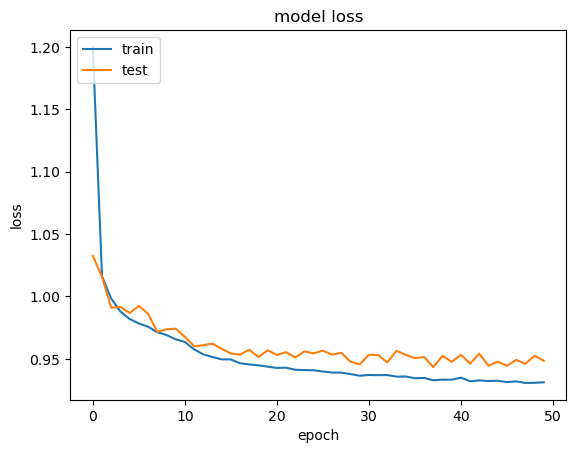

In [ ]:
# INITIAL TRAINING THAT WORKS
# specify our batch size, number of epochs, and learning rate
BATCH_SIZE = 800
EPOCHS = 50
LR = 0.005

train(EPOCHS,LR,BATCH_SIZE)

[INFO] epoch: 1...
epoch: 1 train loss: 0.928
[INFO] epoch: 2...
epoch: 2 train loss: 0.927
[INFO] epoch: 3...
epoch: 3 train loss: 0.926
[INFO] epoch: 4...
epoch: 4 train loss: 0.925
[INFO] epoch: 5...
epoch: 5 train loss: 0.924
[INFO] epoch: 6...
epoch: 6 train loss: 0.923
[INFO] epoch: 7...
epoch: 7 train loss: 0.924
[INFO] epoch: 8...
epoch: 8 train loss: 0.923
[INFO] epoch: 9...
epoch: 9 train loss: 0.923
[INFO] epoch: 10...
epoch: 10 train loss: 0.923
[INFO] epoch: 11...
epoch: 11 train loss: 0.923
[INFO] epoch: 12...
epoch: 12 train loss: 0.922
[INFO] epoch: 13...
epoch: 13 train loss: 0.923
[INFO] epoch: 14...
epoch: 14 train loss: 0.922
[INFO] epoch: 15...
epoch: 15 train loss: 0.921
[INFO] epoch: 16...
epoch: 16 train loss: 0.921
[INFO] epoch: 17...
epoch: 17 train loss: 0.921
[INFO] epoch: 18...
epoch: 18 train loss: 0.921
[INFO] epoch: 19...
epoch: 19 train loss: 0.920
[INFO] epoch: 20...
epoch: 20 train loss: 0.920
[INFO] epoch: 21...
epoch: 21 train loss: 0.919
[INFO] epo

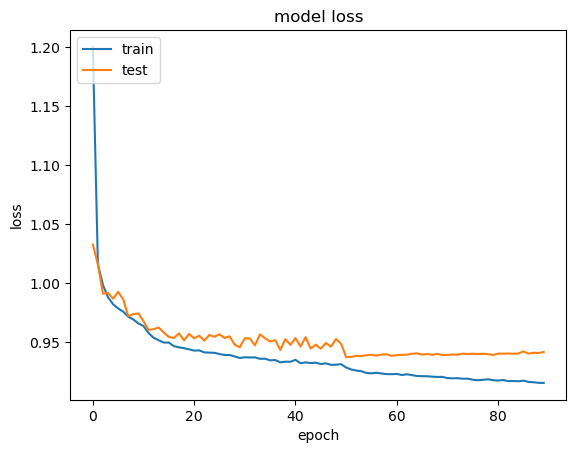

In [ ]:
BATCH_SIZE = 600
EPOCHS = 40
LR = 0.001

train(EPOCHS,LR,BATCH_SIZE)

[INFO] epoch: 1...
epoch: 1 train loss: 0.920
[INFO] epoch: 2...
epoch: 2 train loss: 0.920
[INFO] epoch: 3...
epoch: 3 train loss: 0.919
[INFO] epoch: 4...
epoch: 4 train loss: 0.920
[INFO] epoch: 5...
epoch: 5 train loss: 0.920
[INFO] epoch: 6...
epoch: 6 train loss: 0.920
[INFO] epoch: 7...
epoch: 7 train loss: 0.920
[INFO] epoch: 8...
epoch: 8 train loss: 0.920
[INFO] epoch: 9...
epoch: 9 train loss: 0.920
[INFO] epoch: 10...
epoch: 10 train loss: 0.920
[INFO] epoch: 11...
epoch: 11 train loss: 0.920
[INFO] epoch: 12...
epoch: 12 train loss: 0.920
[INFO] epoch: 13...
epoch: 13 train loss: 0.920
[INFO] epoch: 14...
epoch: 14 train loss: 0.920
[INFO] epoch: 15...
epoch: 15 train loss: 0.920
[INFO] epoch: 16...
epoch: 16 train loss: 0.920
[INFO] epoch: 17...
epoch: 17 train loss: 0.920
[INFO] epoch: 18...
epoch: 18 train loss: 0.920
[INFO] epoch: 19...
epoch: 19 train loss: 0.920
[INFO] epoch: 20...
epoch: 20 train loss: 0.920
[INFO] epoch: 21...
epoch: 21 train loss: 0.921
[INFO] epo

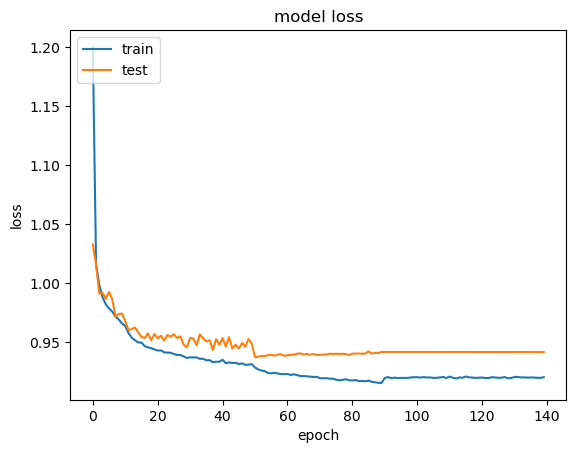

In [ ]:
BATCH_SIZE = 700
EPOCHS = 50
LR = 0.00000001

train(EPOCHS,LR,BATCH_SIZE)

### Model Evaluation

In [ ]:
# evaluate loss on test ! 
#Try the model on test data
evaluate()

########## MODEL EVALUATION ##########


 Model used : SimpleSeqNet(
  (dropOut): Dropout(p=0.01, inplace=False)
  (lin1): Linear(in_features=39, out_features=70, bias=True)
  (lin2): Linear(in_features=70, out_features=70, bias=True)
  (lin3): Linear(in_features=70, out_features=70, bias=True)
  (lin4): Linear(in_features=70, out_features=70, bias=True)
  (out): Linear(in_features=70, out_features=1, bias=True)
) 
 Number of Hashtag features :  30 
 Number of basic features : 9
 Total features :  39 
 MAE on train :  0.9202420923450344 
 
MAE on test :  0.941485583782196


In [ ]:
eval_pred = model(X_eval)

ExportResults(eval_pred,"results.csv")

results.csv written in shared Folder


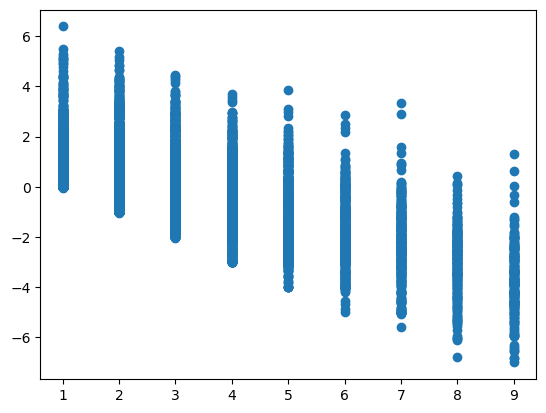

In [ ]:

Y_pred = model(X_test)
Y_pred = Y_pred.detach().numpy()
Y_true = Y_test.detach().numpy()

plt.scatter(Y_true, (Y_pred - Y_true))
plt.show()

In [ ]:
Stop    

NameError: name 'Stop' is not defined

grid search cv

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


X_train, X_test, Y_train, Y_test = train_test_split(X_train_N,Y_train_full,test_size=0.3,random_state=42) 

reg = RandomForestRegressor(n_estimators = 100, max_features = 39, max_depth = 10, random_state = 10).fit(X_train,Y_train)

Y_pred = reg.predict(X_test)

rand_forest_MAE = mean_absolute_error(Y_test, Y_pred)

print("\nMean Absolute error with random forest : ", rand_forest_MAE)




Mean Absolute error with random forest :  7.922787863588218


## Finding the best hypeparameters

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_N,Y_train_full,test_size=0.3,random_state=42) 

### Random search

We start our search by using RandomSearchCV. 

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values. 

### Random Hyperparameter Grid

To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Random Search Training

Now, we instantiate the random search and fit it

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


We can view the best parameters:

In [ ]:
rf_random.best_params_

### Evaluate Random Search

In [ ]:

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


### Grid Search with Cross Validation

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, Y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


In [ ]:
## imports needed : we use tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense #Pour instancier une couche Dense et une d'Input
from tensorflow.keras.models import Model


### Cross correlation
For this model we risk overfitting if using too much parameters, thus we will split the data in order to perform cross correlation to properly assess our model's performance


In [ ]:
#split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_train_N,Y_train_full,test_size=0.10,random_state=42) 

### Model Definition
Here we define our model:

In [ ]:
## Model Parameters 

num_features = len(X_train.iloc(0)[0])
print("Found ",num_features," features in training data\n")


## Layers Definition
inputs = Input(shape=(num_features,),name="input")

hidden = Dense(units = 80, activation = "ReLU", name = "Hidden1")
hidden2 = Dense(units = 700, activation = "ReLU", name = "Hidden2")
hidden3 = Dense(units = 300, activation = "ReLU", name = "Hidden3")
dense2 = Dense(units = 1, activation = "ReLU", name = "out")

## Network assembly

x = hidden(inputs)
x = hidden2(x)
x = hidden3(x)
outputs = dense2(x)

## Model Creation
KerasModel = Model(inputs = inputs, outputs = outputs)
KerasModel.summary()



Found  139  features in training data

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 139)]             0         
                                                                 
 Hidden1 (Dense)             (None, 80)                11200     
                                                                 
 Hidden2 (Dense)             (None, 700)               56700     
                                                                 
 Hidden3 (Dense)             (None, 300)               210300    
                                                                 
 out (Dense)                 (None, 1)                 301       
                                                                 
Total params: 278,501
Trainable params: 278,501
Non-trainable params: 0
_________________________________________________________________


### Model Training

we use here accuracy as a following metric

In [ ]:
# Compile the model
opt = tf.optimizers.Adam(learning_rate=0.001)

KerasModel.compile(loss = "mean_absolute_error",
              optimizer = opt,
              metrics = ["accuracy"])


# Train it
history = KerasModel.fit(X_train,Y_train,epochs=30,batch_size=800,validation_split=0.1)

Epoch 1/30
183/183 [==============================] - 2s 9ms/step - loss: 29.1998 - accuracy: 0.2303 - val_loss: 30.5202 - val_accuracy: 0.2318
Epoch 2/30
183/183 [==============================] - 1s 7ms/step - loss: 29.0810 - accuracy: 0.2334 - val_loss: 30.4357 - val_accuracy: 0.2318
Epoch 3/30
183/183 [==============================] - 1s 8ms/step - loss: 28.9457 - accuracy: 0.2334 - val_loss: 30.1507 - val_accuracy: 0.2318
Epoch 4/30
183/183 [==============================] - 1s 8ms/step - loss: 27.2168 - accuracy: 0.2334 - val_loss: 22.9469 - val_accuracy: 0.2318
Epoch 5/30
183/183 [==============================] - 2s 8ms/step - loss: 20.6601 - accuracy: 0.2334 - val_loss: 19.4990 - val_accuracy: 0.2318
Epoch 6/30
183/183 [==============================] - 1s 8ms/step - loss: 18.0100 - accuracy: 0.2334 - val_loss: 17.7120 - val_accuracy: 0.2318
Epoch 7/30
183/183 [==============================] - 1s 8ms/step - loss: 16.7073 - accuracy: 0.2334 - val_loss: 17.5426 - val_accuracy:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.00001)

KerasModel.compile(loss = "mean_absolute_error",
              optimizer = opt,
              metrics = ["accuracy"])

history = KerasModel.fit(X_train,Y_train,epochs=50,batch_size=600,validation_split=0.1)

Epoch 1/50
244/244 [==============================] - 2s 8ms/step - loss: 12.1437 - accuracy: 0.2334 - val_loss: 14.8590 - val_accuracy: 0.2318
Epoch 2/50
244/244 [==============================] - 2s 8ms/step - loss: 11.9408 - accuracy: 0.2334 - val_loss: 14.7451 - val_accuracy: 0.2318
Epoch 3/50
244/244 [==============================] - 2s 8ms/step - loss: 11.8489 - accuracy: 0.2334 - val_loss: 14.6768 - val_accuracy: 0.2318
Epoch 4/50
244/244 [==============================] - 2s 9ms/step - loss: 11.7883 - accuracy: 0.2334 - val_loss: 14.6339 - val_accuracy: 0.2318
Epoch 5/50
244/244 [==============================] - 2s 10ms/step - loss: 11.7411 - accuracy: 0.2334 - val_loss: 14.5924 - val_accuracy: 0.2318
Epoch 6/50
244/244 [==============================] - 2s 10ms/step - loss: 11.7045 - accuracy: 0.2334 - val_loss: 14.5678 - val_accuracy: 0.2318
Epoch 7/50
244/244 [==============================] - 3s 11ms/step - loss: 11.6772 - accuracy: 0.2334 - val_loss: 14.5397 - val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


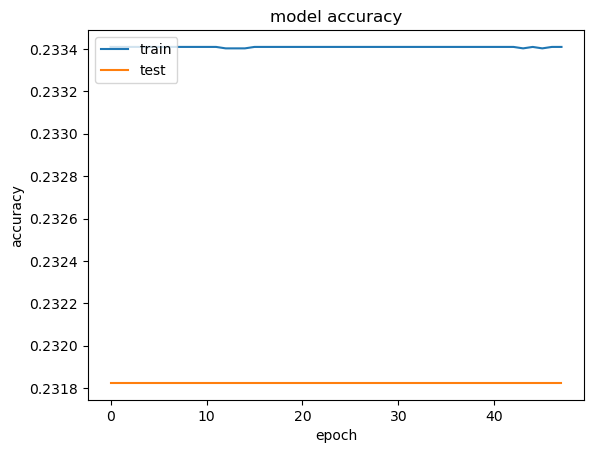

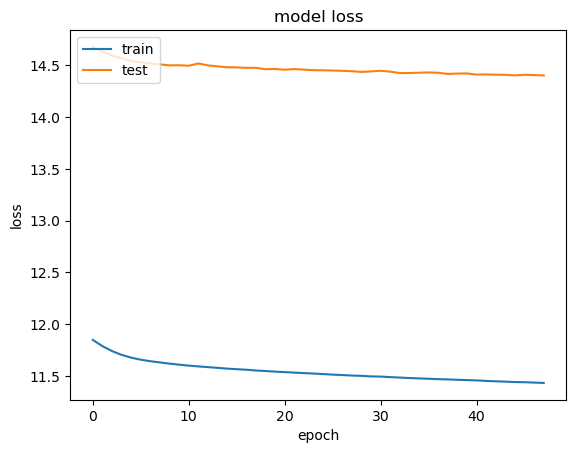

In [ ]:
# Display perfs
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'][2:])
plt.plot(history.history['val_accuracy'][2:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Evaluation

In [ ]:
#Try the model on test data
test_pred = KerasModel.predict(X_test)

NNMAE = mean_absolute_error(Y_test, test_pred)

print("\nMean Absolute error of the model : ", NNMAE)

565/565 [==============================] - 1s 1ms/step

Mean Absolute error of the model :  13.60952665434298


In [ ]:
#predict on evaluation data

eval_pred = KerasModel.predict(X_eval_N)

ExportResults(eval_pred,"results.csv")

3688/3688 [==============================] - 6s 2ms/step
results.csv written in shared Folder


In [ ]:
Stop

NameError: name 'Stop' is not defined

In [ ]:


# Implement Training of the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [ ]:

# training params
learning_rate = 1e-3
epochs = 15

# use MAE loss
loss_function = nn.L1Loss()

#define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer)
    test_loop(test_loader, model, loss_function)
print("Done!")


In [ ]:
Stop

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [ ]:
X_train_nmf_text = []
X_eval_nmf_text = []
Y_train_full = raw_train_data["retweets_count"]

vectorizer = TfidfVectorizer(max_features=80, stop_words=stopwords.words('french'))
X_train_txt = vectorizer.fit_transform(raw_train_data['text'])
X_test_txt = vectorizer.transform(raw_evaluation_data['text'])


#transform raw data 
features= vectorizer.get_feature_names_out()
#construct a dictionnary using the get features names out

array_train=X_train_txt.toarray()
array_test=X_test_txt.toarray()

text_dict=[]
full_dict=[]

for index, row in raw_train_data.iterrows():
    text_dict = dict(map(lambda i,j : (i,j) , features,array_train[index,:]))
    full_dict = extractFeatures(row)
    full_dict.update(text_dict)
    X_train_nmf_text.append(full_dict)

text_dict=[]
full_dict=[]

for index, row in raw_evaluation_data.iterrows():
    text_dict = dict(map(lambda i,j : (i,j) , features,array_test[index,:]))
    full_dict = extractFeatures(row)
    full_dict.update(text_dict)
    X_eval_nmf_text.append(full_dict)

print(X_train_nmf_text)

#get dataframe format
X_train_full_with_text = pd.DataFrame.from_records(X_train_nmf_text)
print(X_train_full_with_text.shape)
X_eval_full_with_text = pd.DataFrame.from_records(X_eval_nmf_text)
X_train_full_with_text.head()

In [ ]:
from sklearn.model_selection import train_test_split

#split the data
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_train_full_with_text,Y_train_full,test_size=0.10,random_state=42) 

In [ ]:
#we need to convert the data from Numpy arrays to Tensors
Y_train_2 = torch.tensor(Y_train_2.values).float().unsqueeze(1) # .to(device)
Y_test_2 = torch.tensor(Y_test_2.values).float().unsqueeze(1)
X_train_2 = torch.tensor(X_train_2.values).float()
X_test_2 = torch.tensor(X_test_2.values).float()

# Also define the evaluation data tensor 
X_eval_2 = torch.tensor(X_eval_N.values).float()

# Load Them in our Data Loader
train = TensorDataset(X_train_2, Y_train_2)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = TensorDataset(X_test_2, Y_test_2)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=True)

# sanity Check
train_features_2, train_labels_@ = next(iter(train_loader))
print(f"Feature training  shape: {X_train.size()}")
print(f"Labels training  shape: {Y_train.size()}")


In [ ]:
num_features_2 = len(X_train_2.iloc(0)[0])

class Net2(nn.Module):
    def __init__(self):
      super(Net, self).__init__()


      #define two dense layers: 
      # can also be done with nn.Sequential that wraps dense linear layers and relu fx

      self.lin1 = nn.Linear(num_features_2, 120)

      self.lin2 = nn.Linear(120, 90)
      
      self.lin3 = nn.Linear(90, 70)

      self.out = nn.Linear(70,1)


    # x represents our data
    def forward(self, x):

      # Pass data through first layer 
      x = self.lin1(x)
      x = F.relu(x)

      # second layer
      x = self.lin2(x)
      x = F.relu(x)

      # second layer
      x = self.lin3(x)
      x = F.relu(x)


      # Regression
      x = self.out(x)
      output = F.relu(x)

      return output

model_2 = Net2()
model_2.to(device)
print(model_2)
